In [1]:
import numpy as np
import random

In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.plotting import scatter_matrix

In [5]:
#Read from CSV to pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0)
df = df.sample(frac=1).reset_index(drop=True) #shuffling
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [6]:
# Define X and y
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

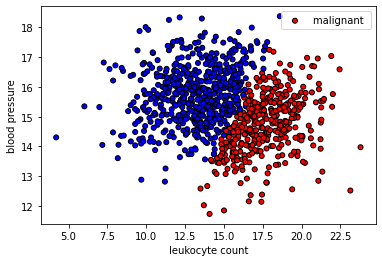

In [7]:
# Plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(['malignant ', 'benign'], loc="upper right")
plt.show()

In [8]:
import collections
from sklearn.model_selection import train_test_split

In [9]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [10]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [12]:
# Overall class distribution
class_counts = dict(collections.Counter(y))
print (f"Classes: {class_counts}")
print (f"m:b = {class_counts['malignant']/class_counts['benign']:.2f}")

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [13]:
import itertools

In [14]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [15]:
#Fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [16]:
# Encoder
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")
print (f"decoded: {label_encoder.decode([y_train[0]])}")

y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [17]:
#Class Weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [20]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [21]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


In [22]:
INPUT_DIM = X_train.shape[1] # X is 2D
NUM_CLASSES = len(label_encoder.classes) # y has 2 possibilities (malignant and benign)

In [23]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


In [24]:
# Forward pass [NX2] · [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (700, 2)
sample: [-0.0069945   0.00647147]


In [25]:
#Normalization via Softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (700, 2)
sample: [0.49663356 0.50336644]


In [26]:
#Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 0.70


In [27]:
#Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)

In [28]:
LEARNING_RATE = 1e-1

In [29]:
# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

In [30]:
NUM_EPOCHS = 50

In [31]:
# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 0.661, accuracy: 0.967
Epoch: 10, loss: 0.438, accuracy: 0.973
Epoch: 20, loss: 0.345, accuracy: 0.973
Epoch: 30, loss: 0.294, accuracy: 0.973
Epoch: 40, loss: 0.261, accuracy: 0.973


In [32]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [33]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [34]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.97, test acc: 0.97


In [35]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')

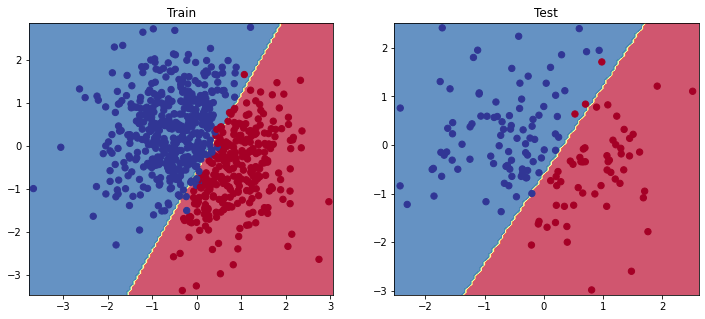

In [36]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [37]:
import torch


In [38]:
# Set seed for reproducibility
torch.manual_seed(SEED)

In [39]:
from torch import nn
import torch.nn.functional as F

In [41]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        y_pred = self.fc1(x_in)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [42]:
#Initialise Model
model = LogisticRegression(INPUT_DIM, NUM_CLASSES)
print(model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


In [44]:
loss_fn = nn.CrossEntropyLoss()
y_pred = torch.randn(3, NUM_CLASSES, requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(NUM_CLASSES)
print(y_true)
loss = loss_fn(y_pred, y_true)
print(f'Loss: {loss.numpy()}')

tensor([1, 0, 0])
Loss: 1.1969707012176514


In [45]:
#Define Class
class_weight_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weight_tensor)

In [46]:
#Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [47]:
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 1, 1])
print(f'Accuracy: {accuracy_fn(y_pred, y_true):.1f}')

Accuracy: 33.3


In [48]:
from torch.optim import Adam

In [52]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [53]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [54]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.96, accuracy: 60.7
Epoch: 10 | loss: 0.28, accuracy: 87.0
Epoch: 20 | loss: 0.15, accuracy: 95.6
Epoch: 30 | loss: 0.12, accuracy: 97.7
Epoch: 40 | loss: 0.10, accuracy: 98.3


In [55]:
from sklearn.metrics import accuracy_score

In [56]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0449, 0.9551], grad_fn=<SelectBackward>)
sample class: 1


In [57]:
# Accuracy (can use self-made accuracy fn)
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.98


In [58]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [59]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [60]:
# Performance report
performance = get_performance(y_true=y_test, y_pred=pred_test, classes=label_encoder.classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9800264101112998,
    "recall": 0.98,
    "f1": 0.9799670975323149,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9824561403508771,
      "recall": 0.9655172413793104,
      "f1": 0.9739130434782608,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.978494623655914,
      "recall": 0.9891304347826086,
      "f1": 0.9837837837837837,
      "num_samples": 92.0
    }
  }
}


In [61]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

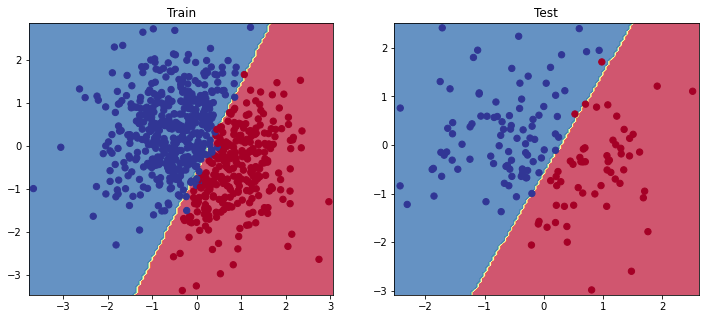

In [62]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [63]:
# Inputs for inference
X_infer = pd.DataFrame([{'leukocyte_count': 13, 'blood_pressure': 12}])

In [64]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[-0.68505296 -3.11487099]]


In [65]:
# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
label = label_encoder.decode(_class.detach().numpy())[0]
print (f"The probability that you have a {label} tumor is {prob.detach().numpy()[0]*100.0:.0f}%")

The probability that you have a benign tumor is 93%


In [66]:
# Unstandardize weights
W = model.fc1.weight.data.numpy()
b = model.fc1.bias.data.numpy()
W_unscaled = W / X_scaler.scale_
b_unscaled = b - np.sum((W_unscaled * X_scaler.mean_))
print (W_unscaled)
print (b_unscaled)

[[ 0.61299698 -1.18550903]
 [-0.9537106   0.88432898]]
[ 8.929324 10.233843]
